# Boosted Decision Tree for DUNE $n\rightarrow\bar{n}$ oscillation sensitivity study 

#### This code computes the 90% C.L. free $n\rightarrow\bar{n}$ oscillation lifetime given the predicted background and exposure of DUNE-FD as per DUNE TDR. This analysis does not take into account systematic uncertainty.

###### Written by: Justin Wheeler at Fermilab
###### Written for the DUNE collaboration as a part of the Science Undergraduate Laboratory Internship (SULI) program
###### Date: 8/6/2024

In [1]:
import ROOT
import uproot
%matplotlib inline
import numpy as np
import pandas as pd
from pylab import*

from sklearn import tree
from sklearn import ensemble

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn import feature_selection

from scipy.stats import poisson
from scipy import integrate

In [2]:
# Import feature variable files

nnbar = uproot.open("nnbar_featurevars_cut_sample.root")
nnbar_tree = nnbar["feats"]
X_nnbar = nnbar_tree.arrays(library="pd")
y_nnbar = pd.DataFrame({"isSignal":np.ones(len(X_nnbar))})

atm = uproot.open("atm_featurevars_cut_sample.root")
atm_tree = atm["feats"]
X_atm = atm_tree.arrays(library="pd")
y_atm = pd.DataFrame({"isSignal":np.zeros(len(X_atm))+0})

X_nnbar.head(4)
X_atm

,num_particles,num_showers,num_tracks,num_p,num_mu,trk_eng,shwr_eng,visible_energy,tot_momentum,invariant_mass,sphericity,aplanarity,FW0,FW1,FW2
0,3,2,1,1,0,129.401688,221.863876,351.265564,141.359955,1160.579346,0.179183,8.970104e-03,1.005796,0.161950,0.500609
1,2,1,1,0,1,8.159128,117.014252,125.173378,201.340195,152.330475,0.004036,-8.607345e-10,2.598567,2.587242,2.564743
2,3,0,3,1,2,566.941833,0.000000,566.941833,522.497437,1400.344360,0.106470,2.831923e-02,1.100183,0.849359,0.507377
3,4,1,3,1,2,208.056107,51.824993,259.881104,255.713409,1323.486938,0.449397,1.480737e-01,2.686990,0.968183,0.164899
4,2,0,2,1,1,674.252380,0.000000,674.252380,692.847595,1354.074951,0.037216,-1.891412e-08,1.166128,1.055919,0.879031


In [5]:
# Import weightes for events

atm_weights_file = uproot.open("atm_weights_cut_sample.root")
atm_weights_tree = atm_weights_file["weight"]
atm_weights = atm_weights_tree.arrays(library="pd")

nnbar_weights = pd.DataFrame({"Weight":np.ones(len(X_nnbar))})

weights = pd.concat([atm_weights, nnbar_weights], ignore_index=False) 

In [6]:
# Concatenate signal and background

X_pre = pd.concat([X_atm, X_nnbar], ignore_index=True)
y_pre = pd.concat([y_atm, y_nnbar], ignore_index=False)

# Cut highly correlated variables
drop_cols = ['FW1', 'FW2', 'aplanarity', 'num_particles', 'trk_eng']

X = X_pre.drop(columns = drop_cols)
y = pd.concat([y_pre,weights],axis=1)
X.head(4)

,num_showers,num_tracks,num_p,num_mu,shwr_eng,visible_energy,tot_momentum,invariant_mass,sphericity,FW0
0,2,1,1,0,221.863876,351.265564,141.359955,1160.579346,0.179183,1.005796
1,1,1,0,1,117.014252,125.173378,201.340195,152.330475,0.004036,2.598567
2,0,3,1,2,0.000000,566.941833,522.497437,1400.344360,0.106470,1.100183
3,1,3,1,2,51.824993,259.881104,255.713409,1323.486938,0.449397,2.686990


In [7]:
# Train classifier

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y['isSignal'], random_state=88, test_size=0.75)

# Train with normalized weights
y_train.loc[y_train['isSignal']==0, 'Weight'] *= (len(y_train[y_train['isSignal']==0]) / np.sum(y_train.loc[y_train['isSignal']==0, 'Weight']))
y_train.loc[y_train['isSignal']==1, 'Weight'] *= (len(y_train[y_train['isSignal']==1]) / np.sum(y_train.loc[y_train['isSignal']==1, 'Weight']))

# Scale testing weights due to sample size change
y_test.loc[y_test['isSignal']==0, 'Weight'] *= (len(y[y['isSignal']==0])/len(y_test[y_test['isSignal']==0]))

dt = tree.DecisionTreeClassifier(max_depth=3, min_samples_split=50)
clf = ensemble.AdaBoostClassifier(estimator=dt, algorithm='SAMME', n_estimators=200)

clf.fit(X_train, y_train['isSignal'], sample_weight=y_train["Weight"])

y_pred = clf.predict(X_test)

In [8]:
# Unweighted results in confusion matrix. Just for sanity check

row_labels = ['True Sig', 'True Bkgd']
column_labels = ['Predicted Sig', 'Predicted Bkgd']

c_mat = pd.DataFrame(confusion_matrix(y_test['isSignal'], y_pred, labels=[1.,0.]), index=row_labels, columns=column_labels)

c_mat

,Predicted Sig,Predicted Bkgd
True Sig,8,0
True Bkgd,4,0


In [9]:
# Feature importances

features = pd.DataFrame(clf.feature_importances_, index = X.columns)
features

,0
num_showers,0.0
num_tracks,0.0
num_p,0.0
num_mu,0.0
shwr_eng,0.0
visible_energy,0.0
tot_momentum,0.0
invariant_mass,0.0
sphericity,0.0
FW0,0.0


In [10]:
# Compute 90% C.L. for number of signal events at DUNE TDR exposure and number of background and 99.98% background rejection

# DUNE TDR number of background
# 2e-4 comes from 99.98% background rejection
n_b = 2886*40*2e-4

# Define the integrand function
def integrand(n_obs, n_s, n_b):
    poisson_ns_nb = poisson.pmf(n_obs, n_s + n_b)
    poisson_nb = poisson.pmf(n_obs, n_b)
    #poisson_ns_nb = (n_s + n_b) ** n_obs * np.exp(-(n_s + n_b)) / factorial(n_obs)
    #poisson_nb = n_b ** n_obs * np.exp(-n_b) / factorial(n_obs)
    return poisson_ns_nb * poisson_nb

# Loop to find normalization constant
norm = 0
for n_s in range(100):
    for n_obs in range(100):
        norm += integrand(n_obs, n_s, n_b)

# Compute the integral as a sum
def integral_result(n_s, n_b):
    result = 0
    for n_obs in range(100):  # Sum over a large range, adjust if needed
        result += integrand(n_obs, n_s, n_b)
    return result

# Function to find the n_s that yields 0.9
def find_ns_90_limit(n_b):
    n_s_low = 0
    n_s_high = 10  # Initial guess for upper bound, adjust if needed
    n_s_result = 0
    for n_s in range(100):  # Sum over a large range, adjust if needed
        n_s_result += integral_result(n_s, n_b) / norm
        if n_s_result > 0.9:
            return n_s

# Find the 90% limit of n_s
n_s_90_limit = find_ns_90_limit(n_b)
print(f"For expected n_b: {n_b:.0f} the 90% limit of n_s is: {n_s_90_limit}")

For expected n_b: 23 the 90% limit of n_s is: 13


In [11]:
# Calculate true positive rate (tpr) and false positive rate (fpr) as a function of BDT response

raw_scores = clf.decision_function(X_test)

sorted_indices = np.argsort(raw_scores)
scores = raw_scores[sorted_indices]
labels = y_test['isSignal'].to_numpy()[sorted_indices]
label_weights = y_test['Weight'].to_numpy()[sorted_indices]

n_sig = np.sum(label_weights[labels == 1])
n_back = np.sum(label_weights[labels == 0])

tpr = zeros(len(scores))
fpr = zeros(len(scores))

N_neutrons = 1.33153e34
T = 10
eff_precut = 0.942
R = 5.6e22 / 5.154e7 # yr^-1

for i in range(len(scores)):
    threshold = scores[i]
    
    tp_indices = (scores >= threshold) & (labels == 1)
    tp = np.sum(label_weights[tp_indices])
    fp_indices = (scores >= threshold) & (labels == 0)
    fp = np.sum(label_weights[fp_indices])

    tpr[i] = tp / n_sig
    fpr[i] = fp / n_back

In [12]:
# Calculate signal efficiency at 99.98% background rejection

min_val = 10
at_response = 0
min_index = 0

for i in range(len(fpr)):
    if (sqrt((2e-4-fpr[i])**2) < min_val):
        min_val = sqrt((2e-4 - fpr[i])**2)
        at_response = scores[i]

min_val = 10
for i in range(len(scores)):
    if (sqrt((at_response - scores[i])**2) < min_val):
        min_val = sqrt((at_response - scores[i])**2)
        min_index = i

DUNE_sig_eff = tpr[min_index]

print(f"For DUNE TDR's background efficiency of .02%, our algorithm obtains an efficiency of {DUNE_sig_eff*100}%")

For DUNE TDR's background efficiency of .02%, our algorithm obtains an efficiency of 100.0%


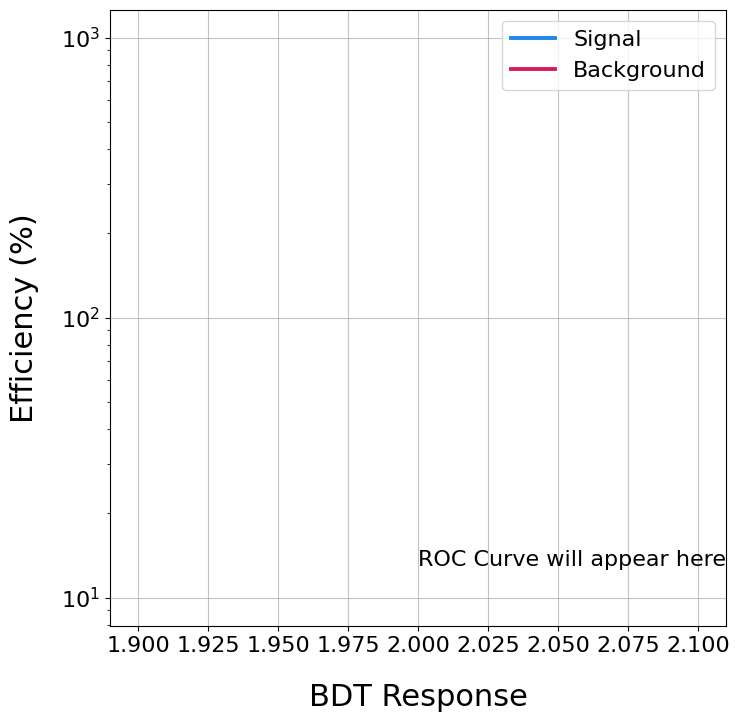

In [24]:
# Plot ROC curve for BDT

fig4,ax4 = plt.subplots(figsize=[8,8])
plt.grid(True, alpha=0.75)

ax4.plot(scores, tpr*100, color="#1E88E5", linewidth=2.8, label="Signal")
ax4.plot(scores, fpr*100, color="#D81B60", linewidth=2.8, label="Background")
#ax4.scatter(scores[min_index], tpr[min_index]*100, color="#1E88E5", marker='o',s=100)
#ax4.scatter(scores[min_index], fpr[min_index]*100, color="#D81B60",marker='o',s=100)

#ax4.axvline(x=at_response, color='k')
#ax4.axhline(y=fpr[min_index]*100, color='k')
#plt.text(at_response,13,'Cut value',rotation=-90, fontsize=16)
plt.text(at_response,13,'ROC Curve will appear here',rotation=0, fontsize=16)

ax4.set_xlabel('BDT Response', fontsize=22, labelpad=20)
ax4.set_ylabel('Efficiency (%)', fontsize=22, labelpad=16)
ax4.set_yscale('log')
plt.yticks(fontsize=16) 
ax4.legend(fontsize=16)

ax4.set_box_aspect(1)

plt.xticks(fontsize=16)  
plt.show()

#fig4.savefig("BDT_ROC_curve_weighted.png", dpi=300, bbox_inches='tight')

In [14]:
# Sensitivity calculation

rate = n_s_90_limit / (N_neutrons * T * eff_precut * DUNE_sig_eff)

T_nnbar = 1/rate # years

tau_nnbar = sqrt(T_nnbar/R)
print(f"Bound nnbar lifetime limit {T_nnbar:.3} yrs")
print(f"Free nnbar lifetime limit {tau_nnbar:.3} s")

Bound nnbar lifetime limit 9.65e+33 yrs
Free nnbar lifetime limit 2.98e+09 s
